--- Baseline Model Performance ---
Accuracy:  0.5712
Precision: 0.4583
Recall:    0.0350
F1-Score:  0.0651


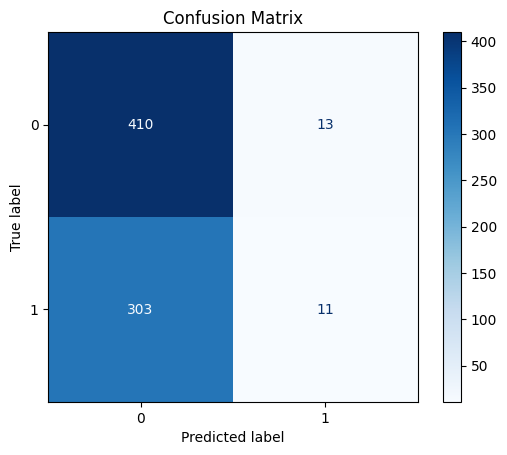

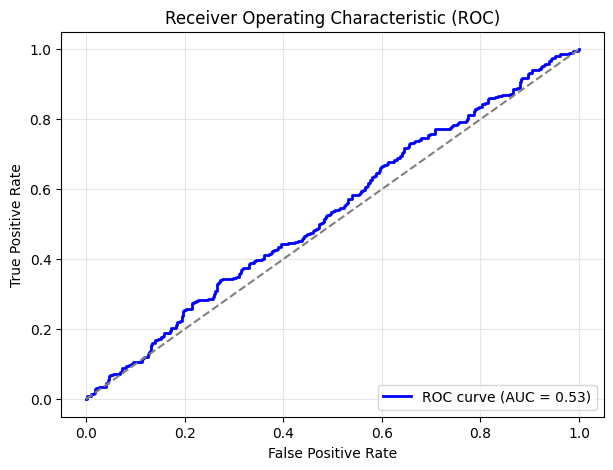

/tmp/ipython-input-1437986298.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='viridis')


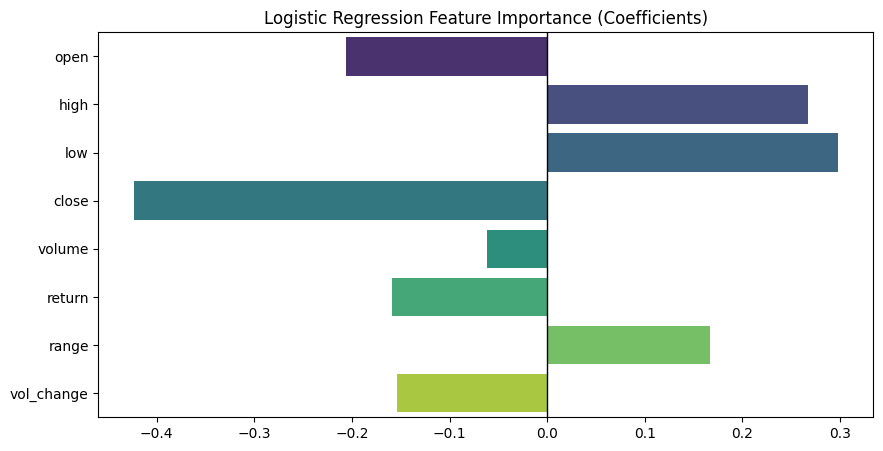


Optimizing model with GridSearchCV...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             classification_report, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from google.colab import files

# --- 1. Load Data ---
# If you haven't uploaded the file yet, uncomment the next two lines:
# uploaded = files.upload()
# df = pd.read_csv('LICI.csv')

# Assuming LICI.csv is already in your Colab file browser:
df = pd.read_csv('LICI.csv')

# --- 2. Feature Engineering ---
# Calculate technical indicators as features
df['return'] = df['close'].pct_change()
df['range'] = (df['high'] - df['low']) / df['close']
df['vol_change'] = df['volume'].pct_change().replace([np.inf, -np.inf], 0)

# Define Target: 1 if close price increases in the next period, else 0
df['target'] = (df['close'].shift(-1) > df['close']).astype(int)

# Select features and drop NaN/Inf values
features = ['open', 'high', 'low', 'close', 'volume', 'return', 'range', 'vol_change']
data = df.dropna().copy()
data.replace([np.inf, -np.inf], 0, inplace=True)

X = data[features]
y = data['target']

# --- 3. Split and Scale Data ---
# Using shuffle=False for time-series data integrity
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 4. Train Logistic Regression (Baseline) ---
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# --- 5. Predict and Evaluate ---
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("--- Baseline Model Performance ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# --- 6. Visualizations ---

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Feature Importance
importance = log_reg.coef_[0]
plt.figure(figsize=(10, 5))
sns.barplot(x=importance, y=features, palette='viridis')
plt.title('Logistic Regression Feature Importance (Coefficients)')
plt.axvline(x=0, color='black', lw=1)
plt.show()

# --- 7. Model Optimization (Hyperparameter Tuning) ---
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

print("\nOptimizing model with GridSearchCV...")
grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000),
                           param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
y_pred_opt = best_model.predict(X_test_scaled)

print("\n--- Optimized Model Results ---")
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred_opt))